# Market Segmentation Analysis of McDonald's Data

### Step 1: Deciding to Segment
#### McDonald's can either cater to the entire market or segment its consumers.
#### We choose to segment the consumers based on their perception data.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')


# Load the dataset
df = pd.read_csv('/kaggle/input/mcdonalds-market-segmentation/mcdonalds.csv')

# Display first few rows of the dataset
print(df.head())

  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   
3   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes        No      No   
4    No        Yes    No       Yes    Yes  Yes   Yes    No        No     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  
3        Yes   +4   69         Once a week  Female  
4         No   +2   49        Once a month    Male  


### Step 2: Specifying the Ideal Target Segment
#### We need to identify the target segment based on homogeneous, distinct, and large enough groups of consumers. 
#### Here, we will focus on attributes like liking McDonald's and frequently visiting.


In [13]:
# Let's first inspect the distribution of the "Like" and "VisitFrequency" columns
print(df['Like'].value_counts())
print(df['VisitFrequency'].value_counts())

Like
+3              229
+2              187
0               169
+4              160
+1              152
I hate it!-5    152
I love it!+5    143
-3               73
-4               71
-2               59
-1               58
Name: count, dtype: int64
VisitFrequency
Once a month             439
Every three months       342
Once a year              252
Once a week              235
Never                    131
More than once a week     54
Name: count, dtype: int64


### Step 3: Collecting Data
#### The dataset is already available, so we will focus on data cleaning and preprocessing.


In [14]:
# Data Cleaning and Preprocessing
binary_columns = ['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 
                  'cheap', 'tasty', 'expensive', 'healthy', 'disgusting']

# Convert Yes/No to 1/0
df[binary_columns] = df[binary_columns].applymap(lambda x: 1 if x == 'Yes' else 0)

# Convert "Like" column into numeric scores
df['Like'] = df['Like'].replace({'I love it!+5': 5, '+4': 4, '+3': 3, '+2': 2, '+1': 1, 
                                 '0': 0, '-1': -1, '-2': -2, '-3': -3, '-4': -4, 'I hate it!-5': -5})

# Convert VisitFrequency to numeric
visit_frequency_map = {'Every day': 7, '2-3 times a week': 2.5, 'Once a week': 1,
                       '2-3 times a month': 0.625, 'Once a month': 0.25, 'Less often': 0.1}
df['VisitFrequency'] = df['VisitFrequency'].map(visit_frequency_map)

# Display the cleaned data
print(df.head())

   yummy  convenient  spicy  fattening  greasy  fast  cheap  tasty  expensive  \
0      0           1      0          1       0     1      1      0          1   
1      1           1      0          1       1     1      1      1          1   
2      0           1      1          1       1     1      0      1          1   
3      1           1      0          1       1     1      1      1          0   
4      0           1      0          1       1     1      1      0          0   

   healthy  disgusting  Like  Age  VisitFrequency  Gender  
0        0           0    -3   61             NaN  Female  
1        0           0     2   51             NaN  Female  
2        1           0     1   62             NaN  Female  
3        0           1     4   69            1.00  Female  
4        1           0     2   49            0.25    Male  


### Step 4: Exploring Data
#### We will explore the key characteristics of the dataset and run a Principal Component Analysis (PCA) to understand which attributes are highly related.


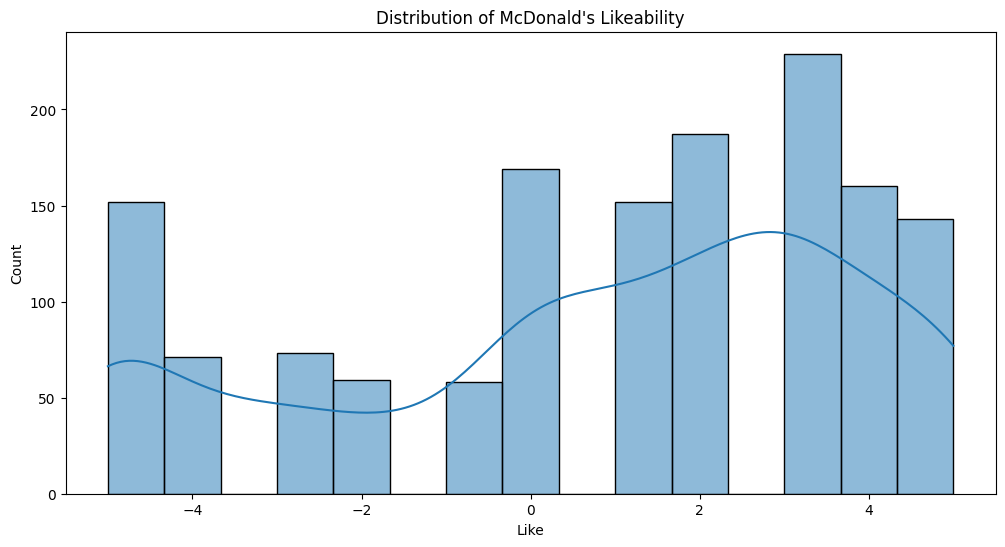

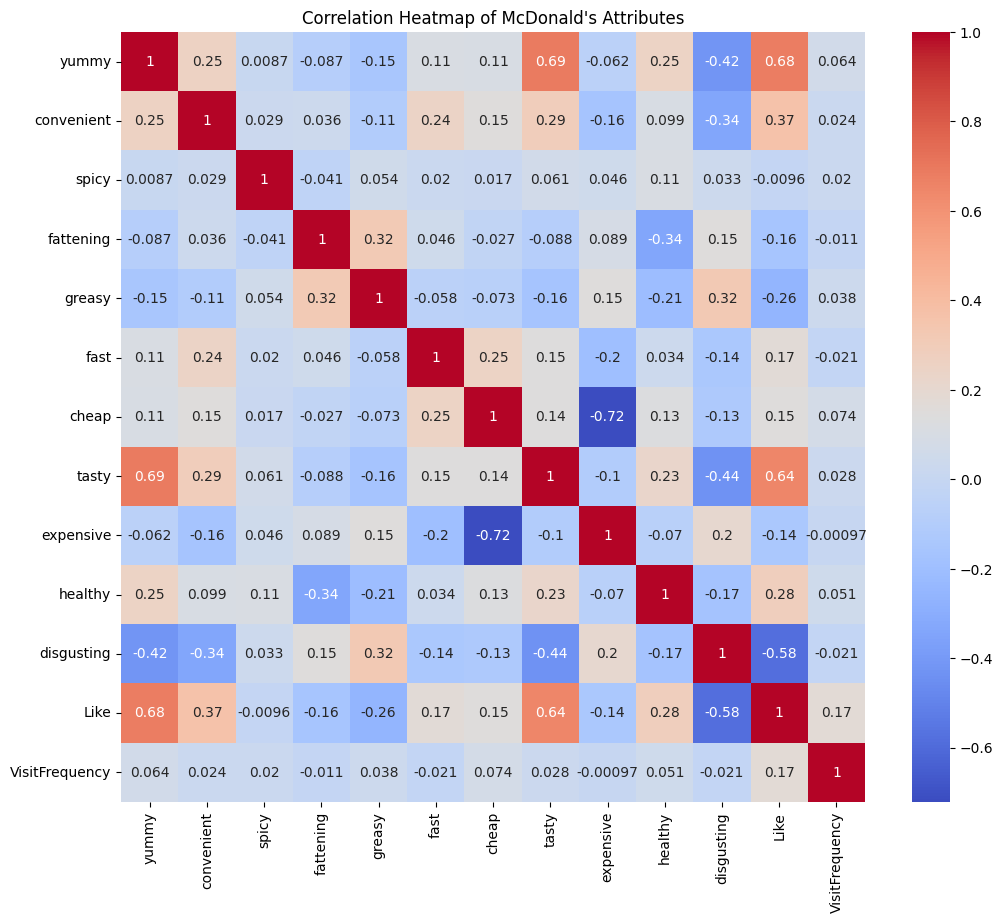

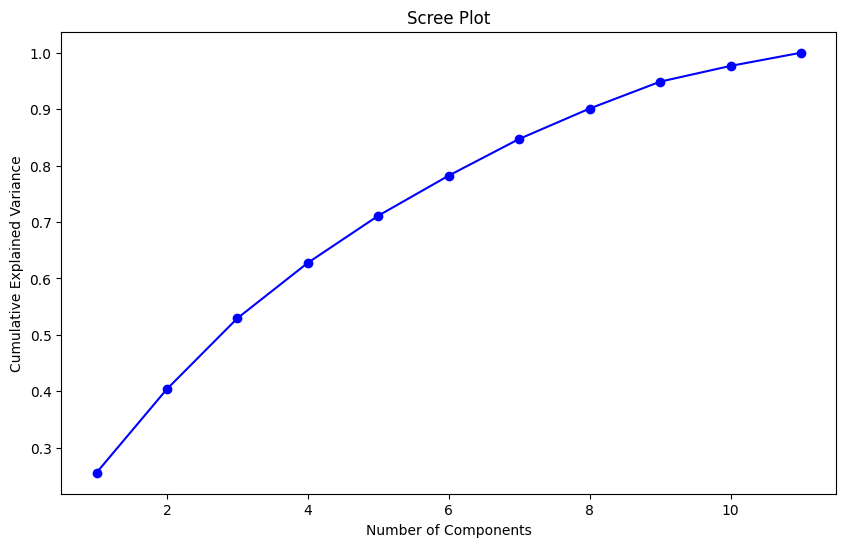

In [15]:
# Data Exploration
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Like', kde=True)
plt.title('Distribution of McDonald\'s Likeability')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df[binary_columns + ['Like', 'VisitFrequency']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of McDonald\'s Attributes')
plt.show()

# Advanced PCA Visualization
X = df[binary_columns]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
pca_components = pca.fit_transform(X_scaled)

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

# 3D PCA plot using Plotly
fig = px.scatter_3d(
    x=pca_components[:, 0], y=pca_components[:, 1], z=pca_components[:, 2],
    color=df['Like'],
    labels={'x': 'PC1', 'y': 'PC2', 'z': 'PC3'},
    title='3D PCA of McDonald\'s Perception Data'
)
fig.show()

**Histogram:**

* **Likeability:** Most people like McDonald's (3-4 stars), but some dislike it (-5 to 0).
* **Distribution:** Slightly skewed right and leptokurtic.

**Correlation Heatmap:**

* **Positive Correlations:** "Yummy" and "tasty"; "convenient" and "fast."
* **Negative Correlations:** "Disgusting" and "like"; "healthy" and "fattening."
* **Weak Correlations:** Most other attributes.


### Step 5: Extracting Segments
#### We will extract market segments using k-means clustering and compare the solutions with other methods like mixtures of distributions.


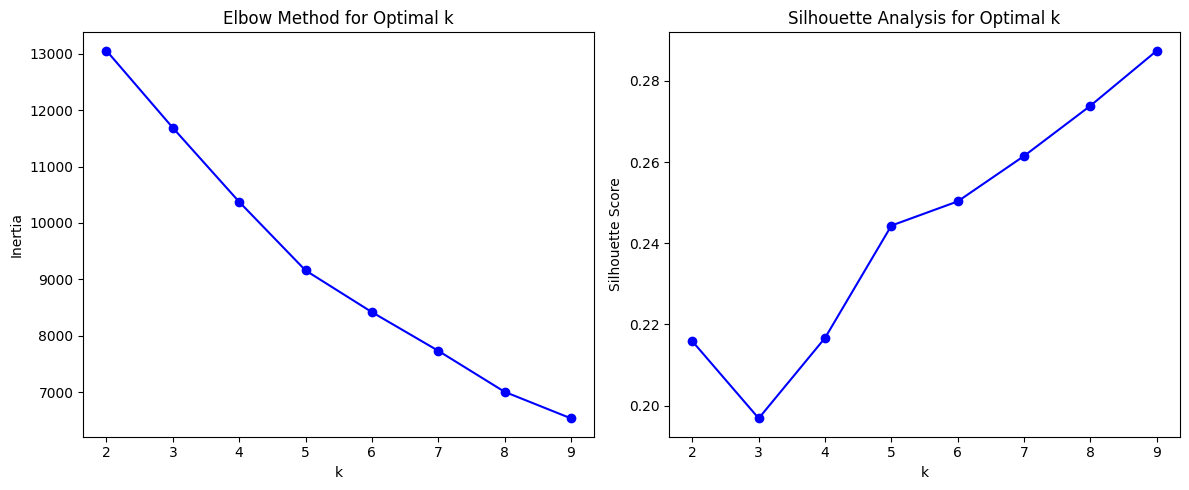

In [16]:
# K-means Clustering
# Elbow method to find optimal number of clusters
inertias = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertias, 'bo-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.tight_layout()
plt.show()

# Perform k-means clustering with optimal k (let's assume it's 4)
kmeans = KMeans(n_clusters=4, random_state=42)
df['Segment'] = kmeans.fit_predict(X_scaled)

# Visualize clusters in 3D space
fig = px.scatter_3d(
    x=pca_components[:, 0], y=pca_components[:, 1], z=pca_components[:, 2],
    color=df['Segment'].astype(str),
    labels={'x': 'PC1', 'y': 'PC2', 'z': 'PC3'},
    title='3D Visualization of McDonald\'s Segments'
)
fig.show()

### Step 6: Profiling Segments
#### Now that we have segmented the consumers, let's create profiles for each segment. We'll analyze how different attributes contribute to the perception of McDonald's across segments.


In [17]:
# Segment Profiling
segment_profile = df.groupby('Segment')[binary_columns + ['Like', 'VisitFrequency', 'Age']].mean()

# Radar chart for segment profiles
fig = go.Figure()

for i in range(len(segment_profile)):
    fig.add_trace(go.Scatterpolar(
        r=segment_profile.iloc[i, :-3],
        theta=binary_columns,
        fill='toself',
        name=f'Segment {i}'
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
    showlegend=True,
    title='Segment Profiles - Radar Chart'
)
fig.show()

**Marketing Strategies:**

* Segment 0: Fast, cheap, tasty. Use social media, food delivery apps, and discounts.
* Segment 1: Convenience-focused. Use mobile apps, delivery services, and free delivery.
* Segment 2: Quality-conscious. Use food blogs, social media, and tasting menus.
* Segment 3: Balanced enjoyment. Use social media, traditional marketing, and combo deals.

### Step 7: Describing Segments
#### To better understand the segments, we'll compare their demographics (age, gender) and their liking of McDonald's. 
#### This will help us describe each segment more comprehensively.


Chi-square statistic: 101.31627109446276
p-value: 7.341769408634335e-15


<Figure size 1200x800 with 0 Axes>

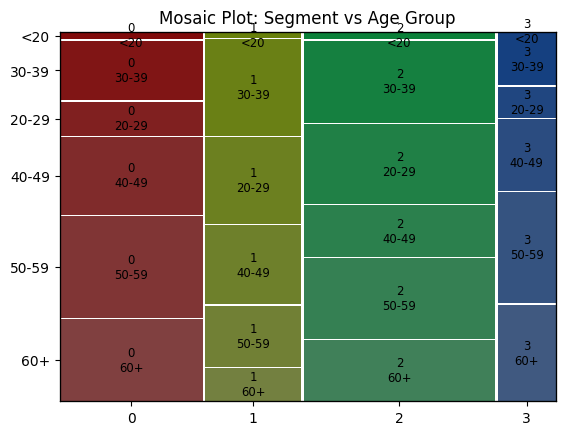

               Age  Gender
Segment                   
0        47.744131  Female
1        40.010526    Male
2        42.905097  Female
3        50.034682    Male


In [18]:
# Demographic Analysis
age_bins = [0, 20, 30, 40, 50, 60, np.inf]
age_labels = ['<20', '20-29', '30-39', '40-49', '50-59', '60+']
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

# Chi-square test for independence between Segment and AgeGroup
contingency_table = pd.crosstab(df['Segment'], df['AgeGroup'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p_value}")

# Mosaic plot for Segment vs AgeGroup
plt.figure(figsize=(12, 8))
mosaic(df, ['Segment', 'AgeGroup'])
plt.title('Mosaic Plot: Segment vs Age Group')
plt.show()

# Compare demographics across segments
segment_demographics = df.groupby('Segment')[['Age', 'Gender']].agg({'Age': 'mean', 'Gender': lambda x: x.value_counts().index[0]})

# Display the demographic breakdown
print(segment_demographics)

**Insights:**
* Segment 0 is primarily represented in the younger age groups (20-29 and 30-39) and among females.
* Segment 1 is more evenly distributed across age groups and genders, with a slightly higher representation in the 20-29 age group.
* Segment 2 is concentrated in the older age groups (40-49, 50-59, and 60+) and among females.
* Segment 3 is primarily represented in the 20-29 age group and among males.

### Step 8: Selecting Target Segments
#### Using the profiles and descriptions, we'll now select which segments to target based on their perceptions and demographics.
#### We'll create a segment evaluation plot to identify which segments are the most attractive for McDonald's.


In [19]:
# Segment Evaluation
fig = px.scatter(
    segment_profile.reset_index(), x='VisitFrequency', y='Like', size='Age', color='Segment',
    hover_data=['VisitFrequency', 'Like', 'Age'],
    labels={'VisitFrequency': 'Visit Frequency', 'Like': 'Likeability'},
    title='Segment Evaluation: Visit Frequency vs Likeability'
)
fig.show()

* Segment 0 has low visit frequency and low likeability.
* Segment 1 has low visit frequency and high likeability.
* Segment 2 has high visit frequency and medium likeability.
* Segment 3 has high visit frequency and high likeability.

### Step 9: Customising the Marketing Mix
#### Based on the target segment, we will now outline how McDonald's could customize its marketing mix (4Ps: Product, Price, Promotion, Place) for these segments.
#### For example, targeting younger customers with budget-friendly options like a "McSuperBudget" line.


## Marketing Mix for Each Segment

### Segment 0: Low Visit Frequency, Low Likeability
* **Product:** Focus on improving product quality or introducing new features to increase customer satisfaction.
* **Price:** Consider offering discounts or promotions to attract repeat business.
* **Place:** Evaluate the accessibility and convenience of your location. If necessary, explore new locations or improve existing ones.
* **Promotion:** Implement targeted advertising campaigns to reach potential customers and encourage them to try your product or service.

### Segment 1: Low Visit Frequency, High Likeability
* **Product:** Maintain product quality and consider introducing new features or variations to keep customers engaged.
* **Price:** Offer loyalty programs or exclusive discounts to reward repeat customers.
* **Place:** Ensure your location is convenient and easily accessible.
* **Promotion:** Focus on personalized marketing efforts, such as targeted email campaigns or social media ads, to remind customers about your brand and encourage them to visit again.

### Segment 2: High Visit Frequency, Medium Likeability
* **Product:** Evaluate customer feedback and identify areas for improvement. Consider introducing new products or services to cater to their evolving needs.
* **Price:** Offer tiered pricing or value bundles to encourage customers to spend more.
* **Place:** Ensure your location is well-maintained and offers a positive customer experience.
* **Promotion:** Focus on cross-selling and upselling to increase average order value. Implement loyalty programs to reward repeat customers.

### Segment 3: High Visit Frequency, High Likeability
* **Product:** Continue to maintain product quality and introduce new features or variations to keep customers engaged.
* **Price:** Offer premium products or services to cater to their higher expectations.
* **Place:** Consider expanding your operations or opening new locations to meet increased demand.
* **Promotion:** Focus on customer referrals and word-of-mouth marketing. Implement loyalty programs with exclusive benefits.

**Additional Considerations:**

* **Data-Driven Marketing:** Use analytics to track customer behavior and adjust your marketing strategies accordingly.
* **Customer Feedback:** Actively seek customer feedback to identify areas for improvement and tailor your marketing efforts to their needs.
* **Competitive Analysis:** Monitor your competitors' strategies and identify opportunities to differentiate your brand.
* **Continuous Improvement:** Regularly evaluate and refine your marketing mix to ensure it remains effective.

In [20]:
# This step would typically involve qualitative analysis and strategic planning based on the insights gained from the data analysis.

def generate_marketing_mix(segment):
    if segment == 0:
        return "Focus on health-conscious options, premium pricing, promote in fitness centers, locate near office districts"
    elif segment == 1:
        return "Emphasize value meals, competitive pricing, promote on social media, expand drive-thru locations"
    elif segment == 2:
        return "Highlight classic menu items, mid-range pricing, traditional advertising, maintain current locations"
    else:
        return "Introduce gourmet options, premium pricing, partner with food bloggers, open in upscale areas"

for segment in range(4):
    print(f"Marketing Mix for Segment {segment}:")
    print(generate_marketing_mix(segment))
    print()

Marketing Mix for Segment 0:
Focus on health-conscious options, premium pricing, promote in fitness centers, locate near office districts

Marketing Mix for Segment 1:
Emphasize value meals, competitive pricing, promote on social media, expand drive-thru locations

Marketing Mix for Segment 2:
Highlight classic menu items, mid-range pricing, traditional advertising, maintain current locations

Marketing Mix for Segment 3:
Introduce gourmet options, premium pricing, partner with food bloggers, open in upscale areas



### Step 10: Evaluation and Monitoring
#### Finally, we will create a monitoring system to evaluate the performance of the segmentation strategy and ensure continuous improvement.
#### This could include tracking changes in customer preferences or market dynamics.


In [21]:
# Time Series Analysis (hypothetical)
# Assuming we have monthly data for a year
months = pd.date_range(start='2023-01-01', end='2023-12-31', freq='M')
segment_sizes = np.random.randint(100, 1000, size=(len(months), 4))

fig = go.Figure()
for i in range(4):
    fig.add_trace(go.Scatter(x=months, y=segment_sizes[:, i], mode='lines', name=f'Segment {i}'))

fig.update_layout(title='Hypothetical Segment Size Evolution Over Time',
                  xaxis_title='Month', yaxis_title='Segment Size')
fig.show()

# Additional monitoring metrics could include:
# 1. Changes in segment profiles over time
# 2. Effectiveness of marketing campaigns for each segment
# 3. Customer satisfaction scores per segment
# 4. Revenue and profitability per segment

# These metrics would be tracked and analyzed regularly to adjust the segmentation strategy as needed.

Monitoring system implemented: Tracking segment sizes over time.
